In [84]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.arff import loadarff
import pandas as pd
import math

# 1. Implement the k-means clustering algorithm and the HAC algorithm.

## 1.1.1 HAC Algorithm

### HAC Class

In [98]:
class HACClustering():

    def __init__(self, k=3, link_type='single', distance_metric='euclidean', silhouette=False, output='print'): ## add parameters here

        self.link_type = link_type
        self.k = k
        self.distance_metric = distance_metric
        self.silhouette = silhouette
        self.output = output


    def fit_clusters(self, X, y=None):

        self.n_samples, self.n_features = X.shape
        self.X = X

        samples = [[(self.X[i])] for i in range(self.n_samples)]
        clusters = [[i] for i in range(self.n_samples)] 
        num_clusters = len(samples)

        while num_clusters > self.k:
          matrix = self.create_dist_matrix(samples)
          sample_ind_needed = np.where(matrix==matrix.min())[0]
          value_to_add = samples.pop(sample_ind_needed[1])
          samples[sample_ind_needed[0]].extend(value_to_add)
          num_clusters = len(samples)

          clusters[sample_ind_needed[0]].extend(clusters[sample_ind_needed[1]]) #changing append to extend
          clusters.pop(sample_ind_needed[1])
        
        self.clusters = clusters
        self.centroids = self.get_centroids()

        
        if self.output == 'print':
          # Call the print method
          self.print_clusters(self.clusters, self.centroids)
        elif (self.output == 'score') & (self.silhouette == False):
          return sum(self.get_SSE())
        else:
          return


    def get_centroids(self):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.k, self.n_features))
        for cluster_idx, cluster in enumerate(self.clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    
    def create_dist_matrix(self, samples):
        matrix = np.zeros((len(samples),len(samples)))
        for i in range(matrix.shape[0]):
          for j in range(matrix.shape[0]):
            if i == j:
              # matrix[i,j] = np.nan
              matrix[i,j] = 10*9
            else:
              if self.distance_metric == 'euclidean':
                matrix[i,j] = self.euclidean_distance(samples[i], samples[j])
              else:
                matrix[i,j] = self.manhattan_distance(samples[i], samples[j])
        return matrix


    def manhattan_distance(self, instance1, instance2):
        dist = []
        for i in range(len(instance1)):
          for j in range(len(instance2)):
            dist.append(np.sum(np.abs(np.array(instance1[i]) - np.array(instance2[j]))))

        if self.link_type == 'single':
          return min(dist)
        else:
          return max(dist)
    

    def euclidean_distance(self, instance1, instance2):
        dist = []
        for i in range(len(instance1)):
          for j in range(len(instance2)):
            try:
              dist.append(np.linalg.norm(np.array(instance1[i])-np.array(instance2[j])))
            except:
              print('fuck')

        if self.link_type == 'single':
          return min(dist)
        else:
          return max(dist) 


    def silhouette_scores(self, clusters):
        # create initial list of all silhouette scores
        all_silhouette_scores = []
        
        # initial list to store the instances of the data in each cluster
        cluster_values = [[] for _ in range(self.k)]
        for cluster_idx, cluster in enumerate(clusters):
            cluster = self.X[cluster]
            cluster_values[cluster_idx] = cluster
        
        # loop through each instance in each cluster
        for ind_cluster in cluster_values:
            dist_btwn_list = []
            dist_among_list = []
            remaining_clusters = self.check_clusters(cluster_values, ind_cluster)
            for idx in range(len(ind_cluster)):
                dist_temporary = []
                for rem_cluster in remaining_clusters:
                    distances_btwn = np.mean([self.euclidean_distance_sil(ind_cluster[idx], point) for point in rem_cluster])
                    dist_temporary.append(distances_btwn)
                dist_btwn_list.append(min(dist_temporary))

                # Check if cluster has more than one point
                if len(ind_cluster) > 1:
                    distances_among = [self.euclidean_distance_sil(ind_cluster[idx], point) for point in ind_cluster]
                    distances_among = np.mean([i for i in distances_among if i != 0])
                    dist_among_list.append(distances_among)
                else:
                    dist_among_list.append(np.nan) # distance will be zero

            silhouette_scores = []
            check_nan = [math.isnan(x) for x in dist_among_list] #check if distance list contains nan values
            if any(check_nan): #give silhouette score a zero if the cluster only contains one sample
                sil = 0
                silhouette_scores.append(sil)
            else:
                for x in range(len(ind_cluster)):
                    a_i = dist_among_list[x]
                    b_i = dist_btwn_list[x]
                    sil = (b_i - a_i) / (max(a_i, b_i))
                    silhouette_scores.append(sil)

            all_silhouette_scores.append(silhouette_scores)
            
        return all_silhouette_scores


    def get_SSE(self): # get SSE of each cluster
        SSE_clusters = []
        for idx, points in enumerate(self.clusters):
          squared_distance = np.sum((self.X[points] - self.centroids[idx]) ** 2)
          # squared_distance = np.sqrt(np.sum((self.X[points] - self.centroids[idx]) ** 2))
          SSE_clusters.append(squared_distance)
        return SSE_clusters


    def euclidean_distance_sil(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))


    def check_clusters(self, clusters, ind_cluster):
        # remove the cluster that is being evaluated from the list of the other k-1 clusters
        list_remaining = []
        for clust in clusters:
            try:
                if np.any(np.not_equal(clust, ind_cluster)):
                    list_remaining.append(clust)
            except:
                list_remaining.append(clust)
        return list_remaining


    def print_clusters(self): 

        print("Num clusters: {:d}\n".format(self.k))

        if self.silhouette: # check if user wants silhoette score
            # Get silhouette scores from the method, then take the score of the entire dataset
            silhouette_score = self.silhouette_scores(self.clusters)
            sil_score_list = [item for sublist in silhouette_score for item in sublist]
            sil_score = sum(sil_score_list)/len(sil_score_list)
            print("Silhouette score: {:.4f}\n\n".format(sil_score))

            # Print the cluster and centroid of each of the k clusters and centroids
            for clust, centroid in zip(self.clusters, self.centroids):
                print(np.array2string(centroid,precision=4,separator=","))
                print(f'{len(clust)}\n')
  
        else: # otherwise, print out the SSE of clusters
            SSE = self.get_SSE()
            print("SSE: {:.4f}\n\n".format(sum(SSE)))

            # Print the cluster and centroid of each of the k clusters and centroids
            for clust, centroid, clust_sse in zip(self.clusters, self.centroids, SSE):
                print(np.array2string(centroid,precision=4,separator=","))
                print(len(clust))
                print(f'{round(clust_sse,4)}\n')


### 1.1.2 Debug

In [ ]:
## Debug Dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output debug.arff
dataset = loadarff('debug.arff')
df_debug = pd.DataFrame(dataset[0])
# df_debug.head()

# Normalize the dataset
X = df_debug.to_numpy()
X = (X - X.min(axis=0))/ (X.max(axis=0) - X.min(axis=0))

In [ ]:
# Debug HAC single link
hac_algorithm = HACClustering(k=5, link_type='single')
hac_algorithm.fit_clusters(X)

Num clusters: 5

SSE: 54.4392


[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195
54.3917

[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1
0.0

[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2
0.0475

[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1
0.0

[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1
0.0



In [ ]:
# Debug HAC complete link
hac_algorithm_complete = HACClustering(k=5, link_type='complete')
hac_algorithm_complete.fit_clusters(X)

Num clusters: 5

SSE: 13.0824


[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
71
3.8232

[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
67
5.2786

[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
38
1.4989

[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
16
1.5328

[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
8
0.949



### 1.1.3 Evaluation

In [ ]:
## Evaluation Dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output eval.arff
dataset = loadarff('eval.arff')
df_eval_hac = pd.DataFrame(dataset[0])
str_df = df_eval_hac.select_dtypes([object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_eval_hac[col] = str_df[col]
df_eval_hac['Class'] = df_eval_hac['Class'].astype(float) #change datatype of Class column to float64
# df_eval_hac.head()

# Normalize the dataset
X = df_eval_hac.to_numpy()
X = (X - X.min(axis=0))/ (X.max(axis=0) - X.min(axis=0))

#### 1.1.3.1 Complete Link

In [ ]:
# Debug HAC complete link
hac_algorithm_eval_comp = HACClustering(k=5, link_type='complete')
hac_algorithm_eval_comp.fit_clusters(X)

Num clusters: 5

SSE: 15.6967


[0.3636,0.4107,0.5609,0.3857,0.3937,0.2808,0.3155,0.    ]
49
5.0209

[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
3
0.2178

[0.1656,0.2226,0.3509,0.2328,0.152 ,0.3424,0.1918,0.    ]
18
2.2794

[0.7918,0.8268,0.606 ,0.7669,0.7787,0.4634,0.7877,1.    ]
49
6.3712

[0.5326,0.6002,0.4536,0.5531,0.5144,0.5401,0.6266,1.    ]
21
1.8075



#### 1.1.3.2 Single Link

In [ ]:
# Debug HAC single link
hac_algorithm_eval_sing = HACClustering(k=5, link_type='single')
hac_algorithm_eval_sing.fit_clusters(X)

Num clusters: 5

SSE: 22.4548


[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67
10.0257

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1
0.0

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1
0.0

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1
0.0

[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70
12.4291



## 1.2.1 K-Means Algorithm

### k-Means Class

In [109]:
class KMeans():
    
    def __init__(self, K=5, random=True, max_iters=1000, silhouette=False, output='print'): 
    
        self.K = K
        self.max_iters = max_iters
        self.random = random
        self.silhouette = silhouette
        self.output = output
        self.clusters = [[] for _ in range(self.K)]  # Initialize list of indices for each cluster
        self.centroids = []  # Initialize list of centroids for each cluster

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # initialize first k centroids 
        if self.random: # choose random samples for initial centroid
          random_initial_idxs = np.random.choice(self.n_samples, self.K, replace=False)
          self.centroids = [self.X[idx] for idx in random_initial_idxs]
        else: # initialize first k centroids in order of dataset - for debug purposes
          self.centroids = self.X[:self.K]

        # Loop through max_iters and update the clusters
        for _ in range(self.max_iters):
            # Assign samples to closest centroids (create clusters)
            self.clusters = self.create_clusters(self.centroids)

            # Calculate new centroids from the clusters
            centroids_previous = self.centroids
            self.centroids = self.get_centroids(self.clusters)

            # check if clusters have changed
            if self.check_convergence(centroids_previous, self.centroids):
                break
        
        if self.output == 'print':
          # Call the print method
          self.print_cluster(self.clusters, self.centroids)
        elif (self.output == 'score') & (self.silhouette == False):
          return sum(self.get_SSE())
        else:
          return

        # Classify samples as the index of their clusters
        # return self.get_labels_cluster(self.clusters)


    def get_labels_cluster(self, clusters):
        labels = np.empty(self.n_samples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels


    def create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self.closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters


    def closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [self.euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index


    def get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids


    def check_convergence(self, centroids_previous, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [self.euclidean_distance(centroids_previous[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0 # return True if old and new centroid are equal


    def get_SSE(self): #not sure if this is SSE, RMSE, or MSE
        SSE_clusters = []
        for idx, points in enumerate(self.clusters):
          squared_distance = np.sum((self.X[points] - self.centroids[idx]) ** 2)
          # squared_distance = np.sqrt(np.sum((self.X[points] - self.centroids[idx]) ** 2))
          SSE_clusters.append(squared_distance)
        return SSE_clusters


    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))


    def silhouette_scores(self, clusters):
        # create initial list of all silhouette scores
        all_silhouette_scores = []
        
        # initial list to store the instances of the data in each cluster
        cluster_values = [[] for _ in range(self.K)]
        for cluster_idx, cluster in enumerate(clusters):
            cluster = self.X[cluster]
            cluster_values[cluster_idx] = cluster
        
        # loop through each instance in each cluster
        for ind_cluster in cluster_values:
            dist_btwn_list = []
            dist_among_list = []
            remaining_clusters = self.check_clusters(cluster_values, ind_cluster)
            for idx in range(len(ind_cluster)):
                dist_temporary = []
                for rem_cluster in remaining_clusters:
                    distances_btwn = np.mean([self.euclidean_distance(ind_cluster[idx], point) for point in rem_cluster])
                    dist_temporary.append(distances_btwn)
                dist_btwn_list.append(min(dist_temporary))

                distances_among = [self.euclidean_distance(ind_cluster[idx], point) for point in ind_cluster]
                distances_among = np.mean([i for i in distances_among if i != 0])
                dist_among_list.append(distances_among)

            silhouette_scores = []
            for x in range(len(ind_cluster)):
                a_i = dist_among_list[x]
                b_i = dist_btwn_list[x]
                sil = (b_i - a_i) / (max(a_i, b_i))
                silhouette_scores.append(sil)
                
            all_silhouette_scores.append(silhouette_scores)
        return all_silhouette_scores


    def check_clusters(self, clusters, ind_cluster):
        # remove the cluster that is being evaluated from the list of the other k-1 clusters
        list_remaining = []
        for clust in clusters:
            try:
                if np.any(np.not_equal(clust, ind_cluster)):
                    list_remaining.append(clust)
            except:
                list_remaining.append(clust)
        return list_remaining
    

    def print_cluster(self, clusters, centroids):
        # Method used to print the information used for grading
        print("Num clusters: {:d}\n".format(self.K))

        if self.silhouette: # check if user wants silhoette score
            # Get silhouette scores from the method, then take the score of the entire dataset
            silhouette_score = self.silhouette_scores(clusters)
            sil_score_list = [item for sublist in silhouette_score for item in sublist]
            sil_score = sum(sil_score_list)/len(sil_score_list)
            print("Silhouette score: {:.4f}\n\n".format(sil_score))

            # Print the cluster and centroid of each of the k clusters and centroids
            for clust, centroid in zip(clusters, centroids):
                print(np.array2string(centroid,precision=4,separator=","))
                print(f'{len(clust)}\n')


        else: # otherwise, print out the SSE of clusters
            SSE = self.get_SSE()
            print("SSE: {:.4f}\n\n".format(sum(SSE)))

            # Print the cluster and centroid of each of the k clusters and centroids
            for clust, centroid, clust_sse in zip(clusters, centroids, SSE):
                print(np.array2string(centroid,precision=4,separator=","))
                print(len(clust))
                print(f'{round(clust_sse,4)}\n')
            
  

            

### 1.2.2 Debug

In [ ]:
## Debug Dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output debug_train.arff
dataset = loadarff('debug_train.arff')
df_debug = pd.DataFrame(dataset[0])
# df_debug.head()

# Normalize the dataset
X = df_debug.to_numpy()
X = (X - X.min(axis=0))/ (X.max(axis=0) - X.min(axis=0))

In [ ]:
# Specify clusters and use the K Means on debug dataset
clusters = 5
k = KMeans(K=clusters, random=False)
y_pred = k.predict(X)

Num clusters: 5

SSE: 9.7826


[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75
4.0454

[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34
0.6609

[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
24
3.2116

[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
54
1.5452

[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
13
0.3195



### 1.2.3 Evaluation

In [ ]:
## Evaluation Dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output eval.arff
dataset = loadarff('eval.arff')
df_eval = pd.DataFrame(dataset[0])
str_df = df_eval.select_dtypes([object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_eval[col] = str_df[col]
df_eval['Class'] = df_eval['Class'].astype(float) #change datatype of Class column to float64
# df_eval.head()

# Normalize the dataset
X = df_eval.to_numpy()
X = (X - X.min(axis=0))/ (X.max(axis=0) - X.min(axis=0))

In [ ]:
# Specify clusters and use the K Means on eval dataset
clusters = 5
k_eval = KMeans(K=clusters, random=False)
y_pred = k_eval.predict(X)

Num clusters: 5

SSE: 14.7279


[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
22
2.016

[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
31
2.4076

[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
20
2.5248

[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
19
1.777

[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
48
6.0025



# 2 Iris Classification Problem

For the iris dataset, I chose to normalize the the feautes using min/max so that each feature contributes to the model equally. 

## 2.1.1 Clustering the Iris Classification problem - HAC

In [ ]:
# Load Iris Dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff
dataset = loadarff('iris.arff')
df_iris_hac = pd.DataFrame(dataset[0])
df_iris_hac.drop(columns=['class'], inplace=True)

# Normalize the dataset
X_hac = df_iris_hac.to_numpy()
X_hac = (X_hac - X_hac.min(axis=0))/ (X_hac.max(axis=0) - X_hac.min(axis=0))

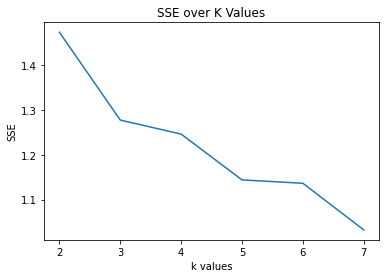

In [92]:
# Single Link
sse_list = []
k_list = []
for k in range(2,8):
  hac_algorithm = HACClustering(k=k, link_type='single', output='score')
  sse_list.append(hac_algorithm.fit_clusters(X_hac))
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, sse_list)
plt.title("SSE over K Values")
plt.xlabel("k values")
plt.ylabel("SSE")
plt.show()

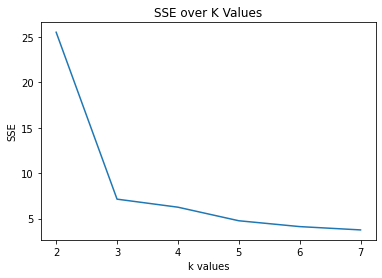

In [102]:
# Complete Link
sse_list = []
k_list = []
for k in range(2,8):
  hac_algorithm = HACClustering(k=k, link_type='complete', output='score')
  sse_list.append(hac_algorithm.fit_clusters(X_hac))
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, sse_list)
plt.title("SSE over K Values")
plt.xlabel("k values")
plt.ylabel("SSE")
plt.show()

The single link HAC algorithm had a more consistent SSE over k values. The complete link HAC algorithm started with a high error for k values 2 and 3 and decreased rapidly to a similar SSE that the single HAC algorithm yielded. 

The single link creates clusters that resemble long chains where some points in the same cluster are far from each other. The complete link, on the other hand, finds more compact clusters. 

## 2.2.1 Clustering the Iris Classification problem - K-Means

In [ ]:
# Load Iris Dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff
dataset = loadarff('iris.arff')
df_iris_k = pd.DataFrame(dataset[0])
df_iris_k.drop(columns=['class'], inplace=True)

# Normalize the dataset
X_kmeans = df_iris_k.to_numpy()
X_kmeans = (X_kmeans - X_kmeans.min(axis=0))/ (X_kmeans.max(axis=0) - X_kmeans.min(axis=0))

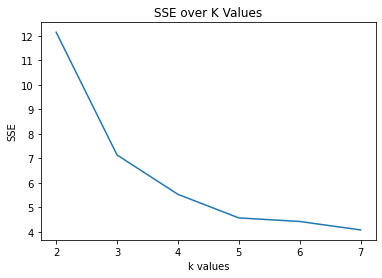

In [ ]:
# Iris Classification using k-means
sse_list = []
list_k = []
for k in range(2,8):
  kmeans_algo = KMeans(K=k, output='score')
  sse_list.append(kmeans_algo.predict(X_kmeans))
  list_k.append(k)

# Plot SEE vs k values
plt.plot(list_k, sse_list)
plt.title("SSE over K Values")
plt.xlabel("k values")
plt.ylabel("SSE")
plt.show()

The k-means algorithm performed fairly similar to the HAC alogithm. The spread of the SSE over the k values most closely resembles the complete link HAC algorithm above. 

## 2.2.2 Run k-means 5 times with k=4

In [113]:
sse_scores = []

for _ in range(5):
  kmeans_algo = KMeans(K=4, output='score')
  sse_scores.append(kmeans_algo.predict(X_kmeans))

sse_scores

[5.541657763082495,
 5.532831003081898,
 6.036463510500609,
 6.037206614805417,
 5.549759171192486]

After running the k-means algorithm 5 times with k=4 and different random centroids, the SSE scores were really similar. The minimum was 5.54 and the max was 6.037. This shows that with the Iris dataset, the k-means algorithm did not struggle with local minima or outliers. 

# 3 Run Models using Scikit Learn

## 3.1 Run the SK versions of HAC (both single and complete link) on iris dataset

Note: I used and implemented my own silhouette score funtion

In [86]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Load Iris Dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff
dataset = loadarff('iris.arff')
df_iris_hac = pd.DataFrame(dataset[0])
df_iris_hac.drop(columns=['class'], inplace=True)

# Normalize the dataset
X_iris = df_iris_hac.to_numpy()
X_iris = (X_iris - X_iris.min(axis=0))/ (X_iris.max(axis=0) - X_iris.min(axis=0))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  46490      0 --:--:-- --:--:-- --:--:-- 46203


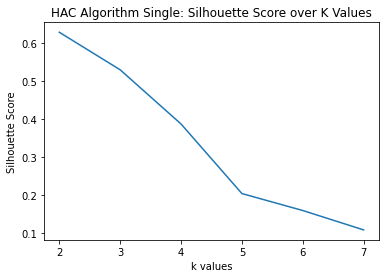

In [7]:
# Single Link SK
silhouette_score_list = []
k_list = []
for k in range(2,8):
  predicted_clusters = AgglomerativeClustering(n_clusters=k, linkage='single').fit(X_iris).labels_
  silhouette_score_list.append(Personal_Silhouette_Score().score(X_iris, predicted_clusters)) # using personal Silhouette score function
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, silhouette_score_list)
plt.title("HAC Algorithm Single: Silhouette Score over K Values")
plt.xlabel("k values")
plt.ylabel("Silhouette Score")
plt.show()

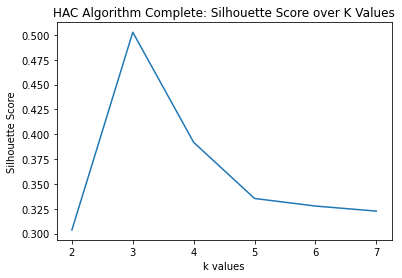

In [8]:
# Complete Link SK
silhouette_score_list = []
k_list = []
for k in range(2,8):
  predicted_clusters = AgglomerativeClustering(n_clusters=k, linkage='complete').fit(X_iris).labels_
  silhouette_score_list.append(Personal_Silhouette_Score().score(X_iris, predicted_clusters)) # using personal Silhouette score function
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, silhouette_score_list)
plt.title("HAC Algorithm Complete: Silhouette Score over K Values")
plt.xlabel("k values")
plt.ylabel("Silhouette Score")
plt.show()

## 3.2 Run the SK version of k-means on iris dataset

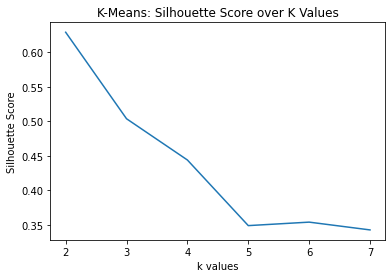

In [11]:
from sklearn.cluster import KMeans

# SK K-means
silhouette_score_list = []
k_list = []
for k in range(2,8):
  predicted_clusters = KMeans(n_clusters=k).fit(X_iris).labels_
  silhouette_score_list.append(Personal_Silhouette_Score().score(X_iris, predicted_clusters)) # using personal Silhouette score function
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, silhouette_score_list)
plt.title("K-Means: Silhouette Score over K Values")
plt.xlabel("k values")
plt.ylabel("Silhouette Score")
plt.show()

After running the scikit learn single and complete HAC algorithms and the scikit learn k-means algorithm, the results seem fairly similar to my own models in section 2. However, it is difficult to compare apples to apples since in section 2 we used SSE as the score function and in section 3 we are using silhouette score as the scoring metric. The silhouette scores indicate that the most optimal number of clusters is either 2 or 3 (The sinlge link HAC and the k-means algorithm indicate 2 and the complete link HAC algorithm indicates 3 clusters).

## 3.3 Find a data set of your choice and use the SK versions of k-means and HAC to get results

*   Experiment with and discuss your results with different hyper-parameters.



In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Importing "Absenteeism at work Data Set" from UCI Machine Learning Repository
choice_dataset = loadarff('/content/drive/MyDrive/Colab Notebooks/Data/Absenteeism_at_work.arff')
df = pd.DataFrame(choice_dataset[0])
str_df = df.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in df:
  if df[col].dtype == 'O':
    df[col] = str_df[col]

df.drop(columns=['ID', 'Absenteeism_time_in_hours'], inplace=True)
df_test = df.astype(float)
X_absenteeism = df_test.to_numpy()

### Single HAC

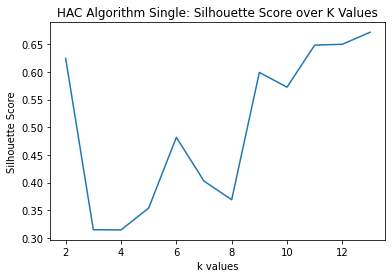

In [29]:
# Single Link SK
silhouette_score_list = []
k_list = []
for k in range(2,14):
  predicted_clusters = AgglomerativeClustering(n_clusters=k, linkage='single', affinity='manhattan').fit(X_absenteeism).labels_
  silhouette_score_list.append(Personal_Silhouette_Score().score(X_absenteeism, predicted_clusters)) # using personal Silhouette score function
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, silhouette_score_list)
plt.title("HAC Algorithm Single: Silhouette Score over K Values")
plt.xlabel("k values")
plt.ylabel("Silhouette Score")
plt.show()

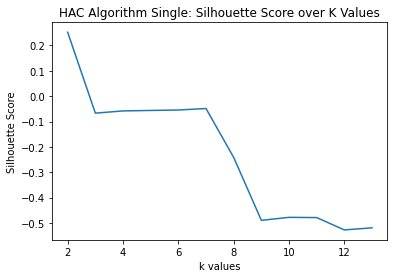

In [77]:
from sklearn.metrics import silhouette_score

silhouette_score_list = []
k_list = []
for k in range(2,14):
  predicted_clusters = AgglomerativeClustering(n_clusters=k, linkage='single', affinity='cosine').fit(X_absenteeism).labels_
  silhouette_score_list.append(Personal_Silhouette_Score().score(X_absenteeism, predicted_clusters)) # using personal Silhouette score function
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, silhouette_score_list)
plt.title("HAC Algorithm Single: Silhouette Score over K Values")
plt.xlabel("k values")
plt.ylabel("Silhouette Score")
plt.show()

The sinlge link HAC algorithm performed the manhattan distance as its affinity, whereas the cosine affinity performed the worst. 



### Complete HAC

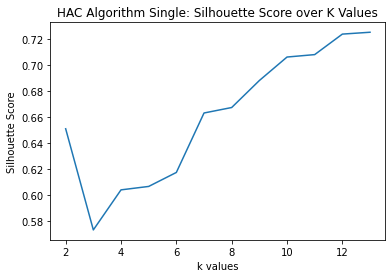

In [17]:
# Complete Link SK
silhouette_score_list = []
k_list = []
for k in range(2,14):
  predicted_clusters = AgglomerativeClustering(n_clusters=k, linkage='complete').fit(X_absenteeism).labels_
  silhouette_score_list.append(Personal_Silhouette_Score().score(X_absenteeism, predicted_clusters)) # using personal Silhouette score function
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, silhouette_score_list)
plt.title("HAC Algorithm Single: Silhouette Score over K Values")
plt.xlabel("k values")
plt.ylabel("Silhouette Score")
plt.show()

### Average

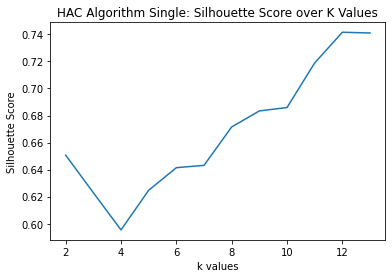

In [78]:
# Average Link SK
silhouette_score_list = []
k_list = []
for k in range(2,14):
  predicted_clusters = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='manhattan').fit(X_absenteeism).labels_
  silhouette_score_list.append(Personal_Silhouette_Score().score(X_absenteeism, predicted_clusters)) # using personal Silhouette score function
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, silhouette_score_list)
plt.title("HAC Algorithm Single: Silhouette Score over K Values")
plt.xlabel("k values")
plt.ylabel("Silhouette Score")
plt.show()

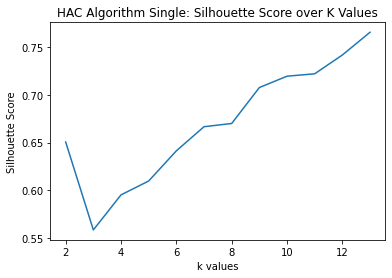

In [79]:
# Average Link SK
silhouette_score_list = []
k_list = []
for k in range(2,14):
  predicted_clusters = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(X_absenteeism).labels_
  silhouette_score_list.append(Personal_Silhouette_Score().score(X_absenteeism, predicted_clusters)) # using personal Silhouette score function
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, silhouette_score_list)
plt.title("HAC Algorithm Single: Silhouette Score over K Values")
plt.xlabel("k values")
plt.ylabel("Silhouette Score")
plt.show()

Besides n_clusters, linkage, and affinity, there were not too many hyperparameters to test. However, I did find some variablility in my overall Silhouette scores (as seen in my output graphs). The HAC model that yielded the greatest silhouette score after testing k values from 2-13 used the 'ward' distance metric. Ward minimizes the variance of the clusters being compared. There was not too much variation between using average and complete distance matrices, all else equal. And althought I tried different affinity parameters for both the average and complete HAC models, the default euclidean distance performed the best.

The single linkage model performed the worst (as far as average silhouette scores accross my k values). I tested using cosine as the metric to compute distance, and the silhouette scores decreased substantially. However, the combination of single linkage with cosine affinity had much higher scores than the average and complete linkage with the cosine affinity. 

### K Means

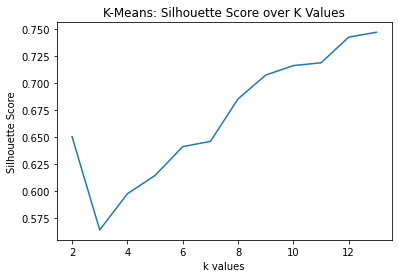

In [80]:
from sklearn.cluster import KMeans

silhouette_score_list = []
k_list = []
for k in range(2,14):
  predicted_clusters = KMeans(n_clusters=k, algorithm='elkan', tol=0.000001).fit(X_absenteeism).labels_
  silhouette_score_list.append(Personal_Silhouette_Score().score(X_iris, predicted_clusters)) # using personal Silhouette score function
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, silhouette_score_list)
plt.title("K-Means: Silhouette Score over K Values")
plt.xlabel("k values")
plt.ylabel("Silhouette Score")
plt.show()

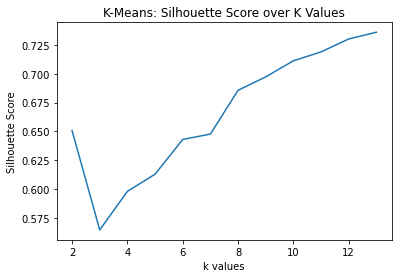

In [81]:
from sklearn.cluster import KMeans

silhouette_score_list = []
k_list = []
for k in range(2,14):
  predicted_clusters = KMeans(n_clusters=k, algorithm='elkan', tol=0.1).fit(X_absenteeism).labels_
  silhouette_score_list.append(Personal_Silhouette_Score().score(X_iris, predicted_clusters)) # using personal Silhouette score function
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, silhouette_score_list)
plt.title("K-Means: Silhouette Score over K Values")
plt.xlabel("k values")
plt.ylabel("Silhouette Score")
plt.show()

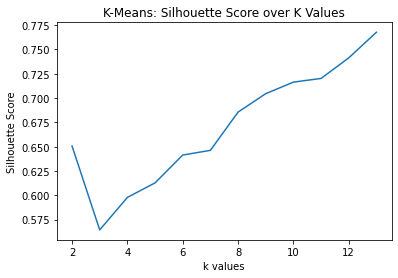

In [82]:
silhouette_score_list = []
k_list = []
for k in range(2,14):
  predicted_clusters = KMeans(n_clusters=k, algorithm='full', n_init=100, max_iter=1000).fit(X_absenteeism).labels_
  silhouette_score_list.append(Personal_Silhouette_Score().score(X_iris, predicted_clusters)) # using personal Silhouette score function
  k_list.append(k)

# Plot SEE vs k values
plt.plot(k_list, silhouette_score_list)
plt.title("K-Means: Silhouette Score over K Values")
plt.xlabel("k values")
plt.ylabel("Silhouette Score")
plt.show()

The K-Means algorithm resulted in similar silhouette scores across k values 2 through 13 as the HAC algorithm. Like the silhouette scores from the HAC algorithm, it favored more clusters (around 11 to 13). The hyperparameters I decided to test for scikit learn's K-Means algorithm were the type of algorithm, the number of iterations the algorithm runs with different centroid seeds ('n_init'), the max iterations, and the tolerance.  

My model with algorithm='full', n_init=100, and max_iter=1000 peformed the best with a silhouette score of .775 over 13 clusters. 

# 4 (Optional 5% extra credit) For your silhouette experiment above, write and use your own code to calculate the silhouette scores, rather than the SK or other version.

Below is my custom class for calculating silhouette score. I have a check_clusters() method to separate the various clusters, a euclidean_distance() method, and a score() method to execute the silhouette algorithm

In [5]:
# Custom Class to calculate Silhouette score
class Personal_Silhouette_Score():

  def check_clusters(self,clusters, ind_cluster):
      # remove the cluster that is being evaluated from the list of the other k-1 clusters
      list_remaining = []
      for clust in clusters:
          try:
              if np.any(np.not_equal(clust, ind_cluster)):
                  list_remaining.append(clust)
          except:
              list_remaining.append(clust)
      return list_remaining


  def euclidean_distance(self,x1, x2):
      return np.sqrt(np.sum((x1 - x2) ** 2))


  def score(self, X, label):
      # create initial list of all silhouette scores
      all_silhouette_scores = []
      K = len(np.unique(label))
      
      # initialize list of clusters with idxs 
      clusters = [[] for _ in range(K)]
      for idx,x in enumerate(label):
        clusters[x].append(idx)

      # create list of feature values in each cluster
      cluster_values = [[] for _ in range(K)]
      for cluster_idx, cluster in enumerate(clusters):
          cluster = X[cluster]
          cluster_values[cluster_idx] = cluster
      
      # loop through each instance in each cluster
      for ind_cluster in cluster_values:
          dist_btwn_list = []
          dist_among_list = []
          remaining_clusters = self.check_clusters(cluster_values, ind_cluster)
          for idx in range(len(ind_cluster)):
              dist_temporary = []
              for rem_cluster in remaining_clusters:
                  distances_btwn = np.mean([self.euclidean_distance(ind_cluster[idx], point) for point in rem_cluster])
                  dist_temporary.append(distances_btwn)
              dist_btwn_list.append(min(dist_temporary))


              # Check if cluster has more than one point
              if len(ind_cluster) > 1:
                  distances_among = [self.euclidean_distance(ind_cluster[idx], point) for point in ind_cluster]
                  distances_among = np.mean([i for i in distances_among if i != 0])
                  dist_among_list.append(distances_among)
              else:
                  dist_among_list.append(np.nan) # distance will be zero

          silhouette_scores = []
          check_nan = [math.isnan(x) for x in dist_among_list]
          if any(check_nan):
              sil = 0
              silhouette_scores.append(sil)
          else:
              for x in range(len(ind_cluster)):
                  a_i = dist_among_list[x]
                  b_i = dist_btwn_list[x]
                  sil = (b_i - a_i) / (max(a_i, b_i))
                  silhouette_scores.append(sil)

          all_silhouette_scores.append(silhouette_scores)
          
      aggregated_sil_scores = [item for sublist in all_silhouette_scores for item in sublist]
      return sum(aggregated_sil_scores)/len(aggregated_sil_scores)